# Film Cooling: Particle Image Velocimetry

![A large round hangar with a closed series of wide green sliding doors in front of a parking lot. The hangar has the NASA logo and a big sign that says "Glenn Research Center" and "Lewis Field".](grc-hangar.jpg)

In [1]:
#!pip install numpyro
#!pip install bayeux-ml

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

In [3]:
%matplotlib inline  
%matplotlib widget

In [4]:
# The raw data is in a custom data format, so we read it in with Python's I/O operations.
with open("raw_nasa_data.dat", "r") as f:
    raw = f.readlines()

# We cut off the first line in the data, since it contains metadata.
raw = raw[1:]

In [5]:
def convert_rows():
    for row in raw:
        # Convert data to float values
        yield np.float64([i.strip() for i in row.split()])

# Create an ndarray from our function
arr = np.fromiter(convert_rows(), dtype=np.ndarray)
# Flatten into a single 2D ndarray
arr = np.stack(arr)

In [6]:
df = pd.DataFrame(arr, columns=["X/D", "Y/D", "Z/D", "U/Uinf", "V/Uinf", "W/Uinf", "Velocity/Uinf", "UVr/Uinf", "y-z Vorticity*D/Uinf",
                               "y-x Vorticity*D/Uinf", "x-z Vorticity*D/Uinf", "w'v'/u_inf^2", "u'w'/u_inf^2", "v'u'/u_inf^2", "sigma U/u_inf",
                               "sigma V/u_inf", "sigma W/u_inf", "Total Turb/u_inf", "sigma UV_r/u_inf", "NUM", "Temp", "Temp'"])
# We need to sample a portion of our dataset because it is so gigantic.
df = df.sample(frac=0.001); df

,X/D,Y/D,Z/D,U/Uinf,V/Uinf,W/Uinf,Velocity/Uinf,UVr/Uinf,y-z Vorticity*D/Uinf,y-x Vorticity*D/Uinf,...,u'w'/u_inf^2,v'u'/u_inf^2,sigma U/u_inf,sigma V/u_inf,sigma W/u_inf,Total Turb/u_inf,sigma UV_r/u_inf,NUM,Temp,Temp'
81531,1.6693,4.8621,1.3732,0.9479,0.0158,-0.0112,0.9481,0.9480,2.581060,14.103385,...,0.0000,0.0000,0.0069,0.0038,0.0040,0.0089,0.0069,399.0,0.0,0.0
206145,5.6693,2.9240,0.3297,0.9408,0.0033,0.0052,0.9408,0.9408,1.755612,70.407707,...,0.0000,0.0000,0.0052,0.0034,0.0042,0.0076,0.0052,400.0,0.0,0.0
131863,3.3360,4.9366,-3.9937,1.1141,-0.0010,-0.0216,1.1143,1.1141,5.936207,7.799853,...,-0.0000,-0.0000,0.0121,0.0055,0.0071,0.0151,0.0121,396.0,0.0,0.0
75953,1.3360,2.4768,-0.2667,0.9585,0.0156,0.0111,0.9587,0.9586,9.875659,133.112880,...,-0.0000,0.0000,0.0088,0.0043,0.0051,0.0110,0.0088,400.0,0.0,0.0
137052,3.3360,2.1786,-4.6646,0.9924,-0.0021,0.0138,0.9925,0.9926,8.418792,-86.019882,...,0.0004,-0.0000,0.0336,0.0157,0.0207,0.0425,0.0336,398.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228547,6.3360,1.7314,0.1806,1.0324,0.0178,0.0020,1.0326,1.0331,6.930061,-80.397499,...,0.0000,0.0001,0.0294,0.0337,0.0188,0.0486,0.0295,387.0,0.0,0.0
59129,0.6693,0.6878,1.5223,0.9038,0.0096,0.0149,0.9039,0.9041,-1.157576,22.746265,...,0.0001,-0.0004,0.0338,0.0211,0.0256,0.0474,0.0336,400.0,0.0,0.0
127700,3.0026,1.7314,3.6840,1.0316,0.0074,-0.0296,1.0320,1.0316,6.255387,62.332012,...,0.0000,0.0000,0.0114,0.0089,0.0089,0.0170,0.0114,395.0,0.0,0.0
148487,3.6693,1.4332,-1.3102,1.0494,-0.0248,0.0342,1.0503,1.0498,25.086508,-34.228138,...,-0.0000,-0.0000,0.0078,0.0078,0.0075,0.0133,0.0078,394.0,0.0,0.0


In [7]:
def plot_3d(x, y, z, c=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    if c is not None:
        scatter = ax.scatter(x, y, z, c=c, cmap="viridis")
        plt.colorbar(scatter)
    else:
        scatter = ax.scatter(x, y, z)
    plt.show()

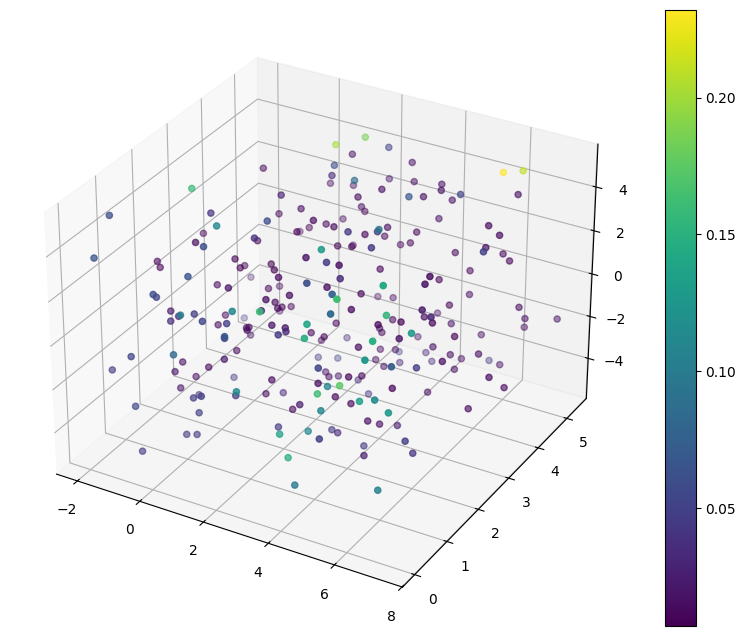

In [8]:
# Domains
x = df["X/D"].to_numpy()
y = df["Y/D"].to_numpy()
z = df["Z/D"].to_numpy()

# Range
values = df["Total Turb/u_inf"].to_numpy()

plot_3d(x, y, z, values)

In [9]:
turb = df["Total Turb/u_inf"].values
x_d = df["X/D"].values[:,None]
y_d = df["Y/D"].values[:,None]
z_d = df["Z/D"].values[:,None]

In [10]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [11]:
with pm.Model() as model_hsgp:
    ℓ_x_d = pm.InverseGamma('ℓ_x_d', **get_ig_params(x_d))
    ℓ_y_d = pm.InverseGamma('ℓ_y_d', **get_ig_params(y_d))
    ℓ_z_d = pm.InverseGamma('ℓ_z_d', **get_ig_params(z_d))
    
    ℓ = pm.math.stack([ℓ_x_d, ℓ_y_d, ℓ_z_d])

    cov = pm.gp.cov.ExpQuad(3, ls=ℓ)
    
    gp = pm.gp.HSGP(m=[10, 10, 10], c=1.5, cov_func=cov)

    X = np.column_stack([x_d, y_d, z_d])
    
    f = gp.prior('f', X=X)
    
    α = pm.HalfNormal('α', 1)
    
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=turb)

    idata_hsgp = pm.sample(target_accept=0.98)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ_x_d, ℓ_y_d, ℓ_z_d, f_hsgp_coeffs, α]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


In [12]:
with model_hsgp:
    ppc = pm.sample_posterior_predictive(idata_hsgp)

Sampling: [y]


Output()

In [13]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

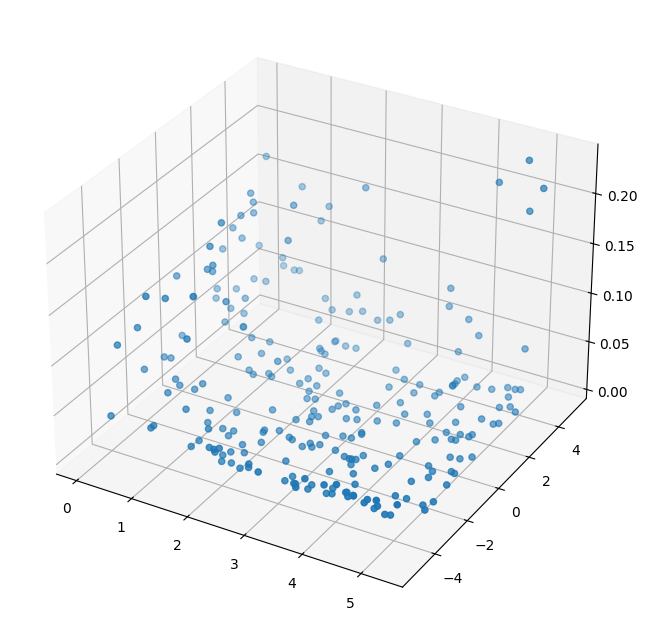

In [14]:
# Domains
x = df["Y/D"].to_numpy()
y = df["Z/D"].to_numpy()

# Range
z = df["Total Turb/u_inf"].to_numpy()

plot_3d(x, y, z)

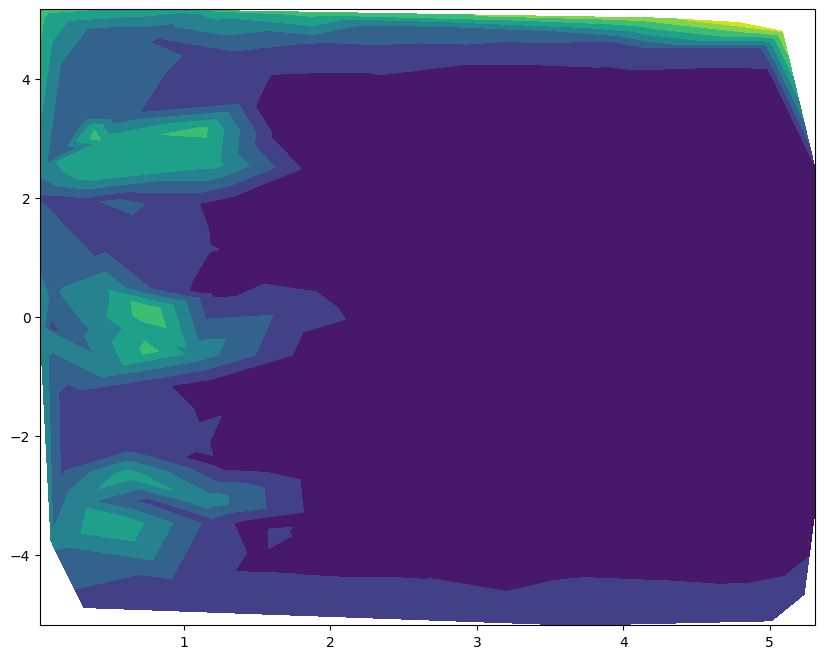

In [15]:
#fig, ax = plt.subplots()
#ax.scatter(x, y, c=z, s=300, marker="s");
plt.clf()
plt.tricontourf(x, y, z); plt.show()

In [16]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model_bmb = bmb.Model("`Total Turb/u_inf` ~ 0 + hsgp(`Y/D`, `Z/D`, c=1.5, m=10)", df, priors=priors)
model_bmb.set_alias({"hsgp(Y/D, Z/D, c=1.5, m=10)": "hsgp"})
model_bmb

       Formula: `Total Turb/u_inf` ~ 0 + hsgp(`Y/D`, `Z/D`, c=1.5, m=10)
        Family: gaussian
          Link: mu = identity
  Observations: 252
        Priors: 
    target = mu
        HSGP contributions
            hsgp(Y/D, Z/D, c=1.5, m=10)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ InverseGamma(alpha: 3.0, beta: 2.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 2.0)

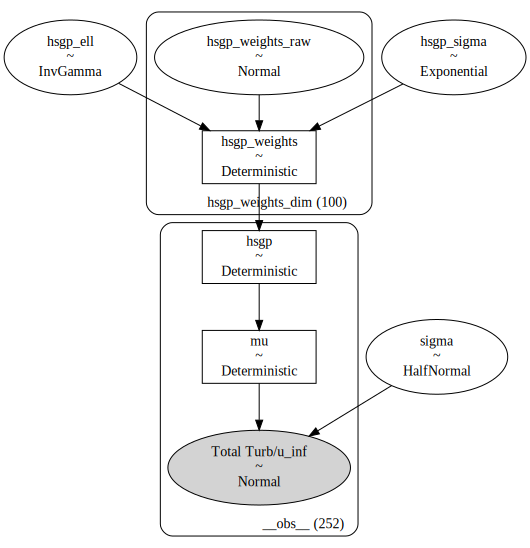

In [17]:
model_bmb.build()
model_bmb.graph()

In [18]:
idata_bmb = model_bmb.fit(inference_method="numpyro_nuts", backend="numpyro", target_accept=0.9, num_chains=4)
print(idata.sample_stats.diverging.sum().item())


 0%|                                                  | 0/1500 [00:00<?, ?it/s]

TypeError: abstract_eval_fun() missing 1 required keyword-only argument: 'debug_info'

In [ ]:
az.plot_trace(
    idata_bmb, 
    var_names=["hsgp_sigma", "hsgp_ell", "sigma"], 
    backend_kwargs={"layout": "constrained"}
);

In [ ]:
bmb.inference_methods.names

## Sources

- [NASA Dataset](https://data.nasa.gov/d/tjbu-3afk)

## Appendix: ChatGPT's explanation of the dataset variables

Here’s an explanation of the variables in the particle image velocimetry (PIV) dataset:

### **Spatial Coordinates**
- **X/D, Y/D, Z/D** – These are the normalized spatial coordinates in the flow field, where $D$ is a characteristic length scale (typically the diameter of the cooling hole). This normalization ensures the results are scalable.
  - $X/D$: Streamwise distance from the cooling hole.
  - $Y/D$: Vertical distance from the cooling hole.
  - $Z/D$: Spanwise distance from the cooling hole.

### **Velocity Components (Normalized)**
- **U/Uinf, V/Uinf, W/Uinf** – These are the velocity components normalized by the free-stream velocity ($U_{\infty}$):
  - $U/U_{\infty}$: Streamwise velocity component.
  - $V/U_{\infty}$: Vertical velocity component.
  - $W/U_{\infty}$: Spanwise velocity component.
- **Velocity/Uinf** – The total velocity magnitude normalized by $U_{\infty}$, defined as:
  $$
  \frac{|\mathbf{V}|}{U_{\infty}} = \frac{\sqrt{U^2 + V^2 + W^2}}{U_{\infty}}
  $$

### **Reynolds Stresses (Normalized)**
- **UVr/Uinf** – Likely represents a specific Reynolds stress term, possibly the shear stress component $ \overline{u' v'} $, normalized by $ U_{\infty} $.
- **w'v'/u_inf^2, u'w'/u_inf^2, v'u'/u_inf^2** – These are the normalized Reynolds stress components:
  - $ \frac{\overline{w' v'}}{U_{\infty}^2} $ – Spanwise-normal Reynolds shear stress.
  - $ \frac{\overline{u' w'}}{U_{\infty}^2} $ – Streamwise-spanwise Reynolds shear stress.
  - $ \frac{\overline{v' u'}}{U_{\infty}^2} $ – Vertical-streamwise Reynolds shear stress.

### **Vorticity Components (Normalized)**
- **y-z Vorticity$*D/Uinf$, y-x Vorticity$*D/Uinf$, x-z Vorticity$*D/Uinf$** – These represent the vorticity components normalized by $ D/U_{\infty} $, given by:
  - $ \omega_{x} = \frac{\partial W}{\partial Y} - \frac{\partial V}{\partial Z} $ (y-z plane vorticity)
  - $ \omega_{y} = \frac{\partial U}{\partial Z} - \frac{\partial W}{\partial X} $ (x-z plane vorticity)
  - $ \omega_{z} = \frac{\partial V}{\partial X} - \frac{\partial U}{\partial Y} $ (y-x plane vorticity)

### **Turbulence Quantities**
- **sigma U/u_inf, sigma V/u_inf, sigma W/u_inf** – These represent the root-mean-square (RMS) fluctuations of velocity components, normalized by $ U_{\infty} $, indicating the turbulence intensity in each direction.
- **Total Turb/u_inf** – Likely the total turbulence intensity, which could be calculated as:
  $$
  \frac{\sqrt{\overline{u'^2} + \overline{v'^2} + \overline{w'^2}}}{U_{\infty}}
  $$
- **sigma UV_r/u_inf** – Could represent the fluctuating component of a Reynolds stress term, possibly $ \sigma_{\overline{u' v'}} $, normalized by $ U_{\infty} $.

### **Additional Variables**
- **NUM** – Likely represents the number of data samples or PIV image pairs used for averaging.
- **Temp** – Mean temperature at a given spatial location.
- **Temp'** – Fluctuating temperature component, likely related to turbulent heat transfer.

These variables provide a detailed representation of both mean and fluctuating flow characteristics in the turbulent jet flow behind the cooling holes, allowing researchers to analyze mixing, turbulence, and cooling effectiveness.